In [1]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# methods
from gaccord import GraphicalAccord, GraphicalConcord

# utils
import sys
sys.path.append('../utils')
from utils import partial_corr, tp_fp, mcc, precision_recall, pseudo_BIC, gauss_BIC, proj_precision_mat
from generate_graphs import generate_erdos_renyi, generate_data

In [2]:
p = 1000
ns = [500, 2000]
edge_prob = 0.03
for n in ns:
    print('n =', n)
    n_prop_to_p = [n/p]
    Theta, Sigma = generate_erdos_renyi(p, type='proj', edge_prob=edge_prob, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, np.sqrt(3)], random_state=2023)
    Rho = partial_corr(Theta)

    Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
    X = Xs[0]

    S = np.matmul(X.T, X)/n
    S.flat[::S.shape[0] + 1] = 0
    lam_max = np.max(np.abs(S))
    lam_min = 0.1 * lam_max
    lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
    if n == 500:
        lams = lams[::-1][6:18] # pre-selected lambdas for erdos renyi with 3% sparsity, n = 0.5p
    elif n == 2000:
        lams = lams[::-1][11:23] # pre-selected lambdas for erdos renyi with 3% sparsity, n = 2p
    
    p_bics, ep_bics_01, ep_bics_02, gauss_bics = [], [], [], []
    edges, precs, recalls, mccs = [], [], [], []

    for lam in lams:
        model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, lam2=0.0, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=500)
        model.fit(X)
        Omega_hat = model.omega_.toarray()
        Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))

        p_bics.append(pseudo_BIC(X, Theta_hat, modified=False))
        ep_bics_01.append(pseudo_BIC(X, Theta_hat, modified=True, gamma=0.1))
        ep_bics_02.append(pseudo_BIC(X, Theta_hat, modified=True, gamma=0.2))
        gauss_bics.append(gauss_BIC(X, Theta_hat))

        tp, fp = tp_fp(Theta, Theta_hat)
        edges.append((len(np.flatnonzero(Theta_hat))-p)/2)
        prec, recall = precision_recall(Theta, Theta_hat)
        precs.append(prec)
        recalls.append(recall)
        mccs.append(mcc(Theta, Theta_hat))

        print('lam:', np.round(lam, 3), ', TP:', tp, ', FP:', fp,\
            ', MCC:', np.round(mcc(Theta, Theta_hat),2),\
            'Precision:', np.round(prec,2),\
            'Recall:', np.round(recall,2))

    # save results
    np.savetxt('data/p_bics_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', p_bics, fmt='%s', delimiter=',')
    np.savetxt('data/ep_bics_01_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', ep_bics_01, fmt='%s', delimiter=',')
    np.savetxt('data/ep_bics_02_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', ep_bics_02, fmt='%s', delimiter=',')
    np.savetxt('data/gauss_bics_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', gauss_bics, fmt='%s', delimiter=',')

    np.savetxt('data/edges_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', edges, fmt='%s', delimiter=',')
    np.savetxt('data/precs_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', precs, fmt='%s', delimiter=',')
    np.savetxt('data/recalls_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', recalls, fmt='%s', delimiter=',')
    np.savetxt('data/mccs_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', mccs, fmt='%s', delimiter=',')
    

n = 500
lam: 0.202 , TP: 300 , FP: 1 , MCC: 0.14 Precision: 1.0 Recall: 0.02
lam: 0.187 , TP: 687 , FP: 11 , MCC: 0.21 Precision: 0.98 Recall: 0.05
lam: 0.173 , TP: 1274 , FP: 29 , MCC: 0.28 Precision: 0.98 Recall: 0.09
lam: 0.159 , TP: 2063 , FP: 102 , MCC: 0.36 Precision: 0.95 Recall: 0.14
lam: 0.147 , TP: 3057 , FP: 339 , MCC: 0.42 Precision: 0.9 Recall: 0.2
lam: 0.136 , TP: 4151 , FP: 840 , MCC: 0.47 Precision: 0.83 Recall: 0.28
lam: 0.126 , TP: 5288 , FP: 1832 , MCC: 0.5 Precision: 0.74 Recall: 0.35
lam: 0.116 , TP: 6380 , FP: 3615 , MCC: 0.51 Precision: 0.64 Recall: 0.43
lam: 0.107 , TP: 7336 , FP: 6297 , MCC: 0.5 Precision: 0.54 Recall: 0.49
lam: 0.099 , TP: 8199 , FP: 10319 , MCC: 0.48 Precision: 0.44 Recall: 0.55
lam: 0.091 , TP: 8977 , FP: 15427 , MCC: 0.45 Precision: 0.37 Recall: 0.6
lam: 0.084 , TP: 9613 , FP: 22269 , MCC: 0.42 Precision: 0.3 Recall: 0.64
n = 2000
lam: 0.107 , TP: 7304 , FP: 8 , MCC: 0.69 Precision: 1.0 Recall: 0.49
lam: 0.099 , TP: 8650 , FP: 17 , MCC: 0.7

### Load saved results

In [2]:
# load results
n, p, edge_prob = 500, 1000, 0.03
p_bics_05p = np.genfromtxt('data/p_bics_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
ep_bics_01_05p = np.genfromtxt('data/ep_bics_01_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
ep_bics_02_05p = np.genfromtxt('data/ep_bics_02_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
gauss_bics_05p = np.genfromtxt('data/gauss_bics_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
best_p_bic_05p = np.argmin(p_bics_05p)
best_ep_bic_01_05p = np.argmin(ep_bics_01_05p)
best_ep_bic_02_05p = np.argmin(ep_bics_02_05p)
best_gauss_bic_05p = np.argmin(gauss_bics_05p)
edges_05p = np.genfromtxt('data/edges_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
precs_05p = np.genfromtxt('data/precs_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
recalls_05p = np.genfromtxt('data/recalls_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
mccs_05p = np.genfromtxt('data/mccs_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')

n, p, edge_prob = 2000, 1000, 0.03
p_bics_2p = np.genfromtxt('data/p_bics_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
ep_bics_01_2p = np.genfromtxt('data/ep_bics_01_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
ep_bics_02_2p = np.genfromtxt('data/ep_bics_02_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
gauss_bics_2p = np.genfromtxt('data/gauss_bics_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
best_p_bic_2p = np.argmin(p_bics_2p)
best_ep_bic_01_2p = np.argmin(ep_bics_01_2p)
best_ep_bic_02_2p = np.argmin(ep_bics_02_2p)
best_gauss_bic_2p = np.argmin(gauss_bics_2p)
edges_2p = np.genfromtxt('data/edges_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
precs_2p = np.genfromtxt('data/precs_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
recalls_2p = np.genfromtxt('data/recalls_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')
mccs_2p = np.genfromtxt('data/mccs_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] + '.txt', delimiter=',')

### Visualization

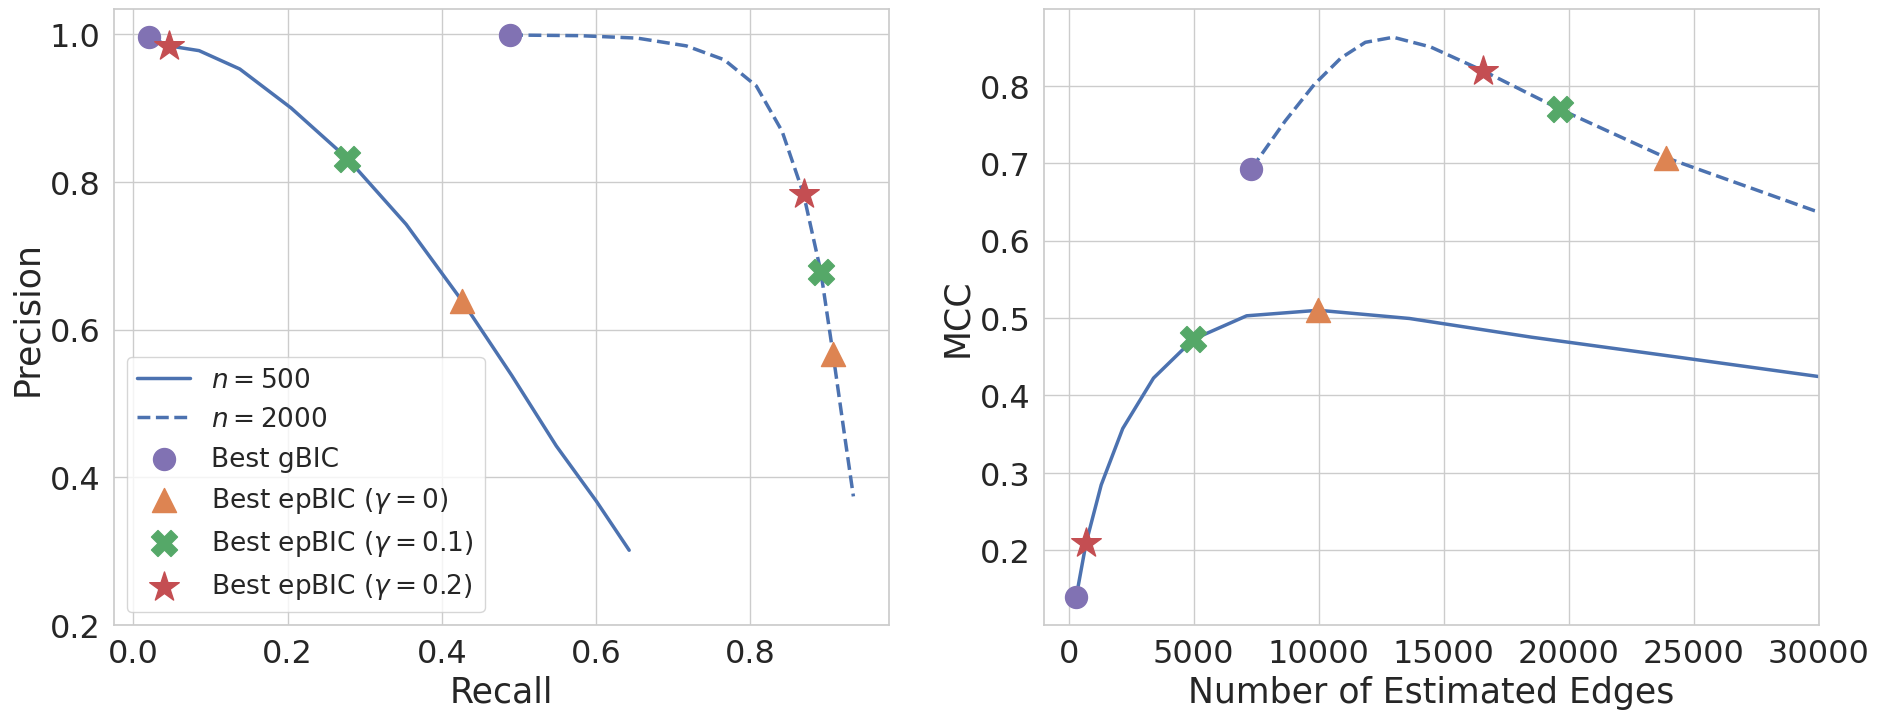

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(recalls_05p, precs_05p, linewidth=2.5, color='C0', label='$n=500$')
axes[i].plot(recalls_2p, precs_2p, linewidth=2.5, linestyle='--', color='C0', label='$n=2000$')
axes[i].scatter(recalls_05p[best_gauss_bic_05p], precs_05p[best_gauss_bic_05p], marker='o', zorder=2, s=250, color='C4', label='Best gBIC')
axes[i].scatter(recalls_05p[best_p_bic_05p], precs_05p[best_p_bic_05p], marker='^', zorder=2, s=300, color='C1', label='Best epBIC ($\gamma = 0$)')
axes[i].scatter(recalls_05p[best_ep_bic_01_05p], precs_05p[best_ep_bic_01_05p], marker='X', zorder=2, s=350, color='C2', label='Best epBIC ($\gamma = 0.1$)')
axes[i].scatter(recalls_05p[best_ep_bic_02_05p], precs_05p[best_ep_bic_02_05p], marker='*', zorder=2, s=500, color='C3', label='Best epBIC ($\gamma = 0.2$)')
axes[i].scatter(recalls_2p[best_p_bic_2p], precs_2p[best_p_bic_2p], marker='^', zorder=2, s=300, color='C1')
axes[i].scatter(recalls_2p[best_ep_bic_01_2p], precs_2p[best_ep_bic_01_2p], marker='X', zorder=2, s=350, color='C2')
axes[i].scatter(recalls_2p[best_ep_bic_02_2p], precs_2p[best_ep_bic_02_2p], marker='*', zorder=2, s=500, color='C3')
axes[i].scatter(recalls_2p[best_gauss_bic_2p], precs_2p[best_gauss_bic_2p], marker='o', zorder=2, s=250, color='C4')
axes[i].set_xlabel('Recall', fontsize=25)
axes[i].set_ylabel('Precision', fontsize=25)
axes[i].set_yticks(np.arange(0.2, 1.2, 0.2))
axes[i].tick_params(axis='both', which='major', labelsize=23)
axes[i].legend(fontsize=19)

i = 1
axes[i].plot(edges_05p, mccs_05p, linewidth=2.5, color='C0')
axes[i].plot(edges_2p, mccs_2p, linewidth=2.5, linestyle='--', color='C0')
axes[i].scatter(edges_05p[best_gauss_bic_05p], mccs_05p[best_gauss_bic_05p], marker='o', zorder=2, s=250, color='C4', label='Best gBIC')
axes[i].scatter(edges_05p[best_p_bic_05p], mccs_05p[best_p_bic_05p], marker='^', zorder=2, s=300, color='C1', label='Best epBIC ($\gamma = 0$)')
axes[i].scatter(edges_05p[best_ep_bic_01_05p], mccs_05p[best_ep_bic_01_05p], marker='X', zorder=2, s=350, color='C2', label='Best epBIC ($\gamma = 0.1$)')
axes[i].scatter(edges_05p[best_ep_bic_02_05p], mccs_05p[best_ep_bic_02_05p], marker='*', zorder=2, s=500, color='C3', label='Best epBIC ($\gamma = 0.2$)')
axes[i].scatter(edges_2p[best_p_bic_2p], mccs_2p[best_p_bic_2p], marker='^', zorder=2, s=300, color='C1')
axes[i].scatter(edges_2p[best_ep_bic_01_2p], mccs_2p[best_ep_bic_01_2p], marker='X', zorder=2, s=350, color='C2')
axes[i].scatter(edges_2p[best_ep_bic_02_2p], mccs_2p[best_ep_bic_02_2p], marker='*', zorder=2, s=500, color='C3')
axes[i].scatter(edges_2p[best_gauss_bic_2p], mccs_2p[best_gauss_bic_2p], marker='o', zorder=2, s=250, color='C4')
axes[i].set_xlabel('Number of Estimated Edges', fontsize=25)
axes[i].set_ylabel('MCC', fontsize=25)
axes[i].set_xlim((-1000,30000))
axes[i].tick_params(axis='both', which='major', labelsize=23)

plt.savefig('../output/model_selection.png', bbox_inches='tight');